Supplementary notebook to the manuscript "Unifying thermochemistry concepts in computational heterogeneous catalysis", by Dr. Bjarne Kreitz (Brown University), Dr. Gabriel S. Gusmão (Georgia Tech), Dingqi Nai (Georgia Tech), Sushree Jagriti Sahoo (Georgia Tech), Prof. Andrew A. Peterson (Brown University), Dr. David H. Bross (Argonne National Laboratory), Prof. C. Franklin Goldsmith (Brown University), Prof. Andrew J. Medford (Georgia Tech). 

Correspondence to Bjarne Kreitz (bjarne_kreitz@brown.edu) and Andrew J. Medford (ajm@gatech.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

eV_to_kJmol=96.485

# Deriving enthalpies of formation of adsorbates using gas-phase reference species

Enthalpies of formation of adsorbates have to be anchored to the existing global thermochemical network of gas-phase species. All species are anchored to the elements in their IUPAC standard states. For this method we are going to form an atomic reference basis set, where we select a single gas-phase species for every element e.g. $[CH_4, H_2, H_2O]$ and Pt(111) for the active site. The enthalpies of formation of the reference species can be obtained from the Active Thermochemical Tables (https://atct.anl.gov/). We assume that the enthalpy of formation of Pt(111) represents bulk Pt and, thus, its enthalpy of formation is 0 by assertion. To determine the enthalpies of formation of the target species with respect to the references in the global thermochemical network, we make a hypothetical reaction to create the target from our references. 

\begin{equation}
    \nu_{CH_4} CH_4 + \nu_{H_2O} H_2O + \nu_{H_2} H_2 + \nu_{*} * \rightarrow P
\end{equation}

The enthalpy of reaction is defined as 
\begin{equation}
\Delta_{\text{r}} H = \sum_{i}^{N} \nu_i  \Delta_{\text{f}} H_i
\end{equation}

where we know the $\Delta_{\text{f}} H_i$ of the reactants (our reference species) from the ATcT. The equation can be rearranged to determine the enthalpy of formation of the target.

\begin{equation}
\Delta_{\text{f}} H_{\text{P}}  = \Delta_{\text{r}} H - \sum_{i\neq P}^{N} \nu_i  \Delta_{\text{f}} H_i
\end{equation}

The enthalpy of reaction can also be computed from the known DFT energies of the target and the reference species. 
\begin{equation}
    \Delta_{\text{f}} H_{\text{P}} = E_{\text{P}} + \sum_{i \neq P}^{N} \nu_i  E_{i}
\end{equation}

Substituting the enthalpy of reaction leads to the equation to determine the enthalpy of formation of the target with respect to the IUPAC refernence species.


\begin{equation}
\Delta_{\text{f}} H_{\text{P}}  = E_{\text{P}} + \sum_{i \neq P}^{N} \nu_i  E_{i} - \sum_{i \neq P}^{N} \nu_i  \Delta_{\text{f}} H_i
\end{equation}

In matrix notation this reads as

\begin{align}
    \mathbf{\underline{H}}_{\text{f}} & =\mathbf{\underline{E}}+\mathbf{\underline{\underline{M}}}\,\mathbf{\underline{E}}^{\text{R}} - \mathbf{\underline{\underline{M}}}\,\mathbf{\underline{H}}_{\text{f}}^{\text{R}}\\
     \mathbf{\underline{H}}_{\text{f}} & =\mathbf{\underline{E}}+\mathbf{\underline{\underline{M}}}\,\left(\mathbf{\underline{E}}^{\text{R}} - \mathbf{\underline{H}}_{\text{f}}^{\text{R}}\right)
\end{align}

where $\mathbf{\underline{\underline{M}}}$ can be determined from the elemental composition matrix of the target species $\mathbf{\underline{\underline{N}}}$ and the reference species $\mathbf{\underline{\underline{N}}}^{\text{R}}$

\begin{equation}
 \mathbf{\underline{\underline{M}}}=-\mathbf{\underline{\underline{N}}}\,\mathbf{\underline{\underline{N}}}^{{\text{R}}^{-1}}
\end{equation}

When anchoring the DFT energies to the global thermochemical network, it is no longer necessary to perform DFT calculations for gas-phase species. Instead, it is possible to simply use the tabulated enthalpies of formation in the ATcT for the gas-phase species as it is in the same reference frame. In our case, we can take known enthalpies of formation for $C_2H_6, C_2H_4, CO, CO_2$. 

This method adjusts all adsorption enthalpies of the gas-phase species that are not used as the references. The enthalpies of adsorption of the references are the DFT values and assumed to be correct. 


This is the list of species with their DFT energies from BEEF-vdW for which we want to compute the enthalpies of formation. We can create a vector $\mathbf{\underline{E}}$ that contains the energies from this dictionary.

In [7]:
#Target species for which we need to compute the EOFs
#all gas-phase species are removed since we use the ATcT values for the enthalpies of formation
species_energies = {
    "C2H6X" : -378231.5655,
    "XH": -377632.6636,
    "XCH2CH3": -378214.9168,
    "XO": -378193.2832,
    "XCH2XCH2": -378198.4442,
    "XCO": -378453.0261, 
    "CO2X": -379030.8164,
    "XOH": -378209.8045,
    "H2OX": -378227.2801,
} #values are in eV

#vector of DFT energies of the target species from the dictionary
E=np.array(list(species_energies.values()))

We want to determine the enthalpies of formation with reference to $[CH_4, H_2, H_2O, Pt(111)]$. For which we determined the DFT energies. We construct the vector $\mathbf{\underline{E}}^{\text{R}}$ that contains the DFT energies of the reference species

In [10]:
ref_energies = {
    "CH4": -324.2935569,
    "H2": -32.69844421, 
    "H2O": -611.0186083,
    "X": -377616.072,
}#values are in eV

#vector of DFT energies of the reference species from the dictionary
E_R=np.array(list(ref_energies.values()))

For the reference species we have to collect the enthalpies of formation from the ATcT

In [11]:
ref_EOF = {
  "CH4":-66.557,
  "H2":0,
  "H2O":-238.929,
  "X":0,
}#values are in kJ/mol

H_R=np.array(list(ref_EOF.values()))

We start now with constructing the elemental composition matrix of our target species $\mathbf{\underline{\underline{N}}}$, which is an $m \times n$ matrix with $m$ target species and $n$ elements. 

In [12]:
# Define the species and their elemental compositions in a dictionary
species_compositions = {
    "C2H6X": {"C": 2, "H": 6, "O": 0, "X": 1},
    "XH": {"C": 0, "H": 1, "O": 0, "X": 1},
    "XCH2CH3": {"C": 2, "H": 5, "O": 0, "X": 1},
    "XO": {"C": 0, "H": 0, "O": 1, "X": 1},
    "XCH2XCH2": {"C": 2, "H": 4, "O": 0, "X": 1},
    "XCO": {"C": 1, "H": 0, "O": 1, "X": 1},
    "CO2X": {"C": 1, "H": 0, "O": 2, "X": 1},
    "XOH": {"C": 0, "H": 1, "O": 1, "X": 1},
    "H2OX": {"C": 0, "H": 2, "O": 1, "X": 1},
}

species=list(species_compositions.keys())

# Create a matrix to hold the elemental compositions of the target species
num_species = len(species_compositions)
num_elements = 4  # C, H, O, X
N = np.zeros((num_species, num_elements))

# Fill in the elemental composition matrix of the target species
for s, composition in species_compositions.items():
    i = species.index(s)
    N[i, :] = [composition["C"], composition["H"], composition["O"], composition["X"]]
    
N

array([[2., 6., 0., 1.],
       [0., 1., 0., 1.],
       [2., 5., 0., 1.],
       [0., 0., 1., 1.],
       [2., 4., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 2., 1.],
       [0., 1., 1., 1.],
       [0., 2., 1., 1.]])

We construct the elemental composition matrix of our reference species $\mathbf{\underline{\underline{N}}}^{\text{R}}$, which is an $m \times n$ matrix with $m$ reference species and $n$ elements. 

In [13]:
# Define the species and their elemental compositions in a dictionary
references_compositions = {
    "CH4": {"C": 1, "H": 4, "O": 0, "X": 0},
    "H2": {"C": 0, "H": 2, "O": 0, "X": 0},
    "H2O": {"C": 0, "H": 2, "O": 1, "X": 0},
    "X": {"C": 0, "H": 0, "O": 0, "X": 1},
}

references=list(references_compositions.keys())

# Create a matrix to hold the elemental compositions of the reference species
num_references = len(references_compositions)
N_R = np.zeros((num_references, num_elements))

# Fill in the elemental composition matrix of the reference species
for s, composition in references_compositions.items():
    i = references.index(s)
    N_R[i, :] = [composition["C"], composition["H"], composition["O"], composition["X"]]
    
N_R

array([[1., 4., 0., 0.],
       [0., 2., 0., 0.],
       [0., 2., 1., 0.],
       [0., 0., 0., 1.]])

We can now determine $\mathbf{\underline{\underline{M}}}$ from the elemental composition matrix of the target species $\mathbf{\underline{\underline{N}}}$ and the reference species $\mathbf{\underline{\underline{N}}}^{\text{R}}$ via

\begin{equation}
 \mathbf{\underline{\underline{M}}}=-\mathbf{\underline{\underline{N}}}\,\mathbf{\underline{\underline{N}}}^{{\text{R}}^{-1}}
\end{equation}

In [14]:
#Calculate the matrix of stoichiometric coefficients to form the target from the reference species
M=-N.dot(np.linalg.inv(N_A))
M

array([[-2. ,  1. , -0. , -1. ],
       [-0. , -0.5, -0. , -1. ],
       [-2. ,  1.5, -0. , -1. ],
       [-0. ,  1. , -1. , -1. ],
       [-2. ,  2. , -0. , -1. ],
       [-1. ,  3. , -1. , -1. ],
       [-1. ,  4. , -2. , -1. ],
       [-0. ,  0.5, -1. , -1. ],
       [-0. , -0. , -1. , -1. ]])

The last step is to compute the enthalpies of formation using the matrix of stoichiometric coefficients of the formation reactions and the DFT energies of the target species and references

\begin{equation}
    \mathbf{\underline{H}}_{\text{f}} =\mathbf{\underline{E}}-\mathbf{\underline{\underline{M}}}\,\mathbf{\underline{E}}^{\text{R}} + \mathbf{\underline{\underline{M}}}\,\mathbf{\underline{H}}_{\text{f}}^{\text{R}}
\end{equation}


In [17]:
#Determine the enthalpy of formation of the target
H_f=(E*eV_to_kJmol+M.dot(E_R)*eV_to_kJmol-M.dot(H_R))

#Create a dictionary with the results
enthalpies_of_formation = {species[i]: H_f[i] for i in range(len(species))}
enthalpies_of_formation

{'C2H6X': -94.98606210941077,
 'XH': -23.385831207036972,
 'XCH2CH3': -66.09093740576506,
 'XO': -131.9305997812152,
 'XCH2XCH2': -54.186821207344536,
 'XCO': -280.13624798363446,
 'CO2X': -467.9413112559914,
 'XOH': -148.53353548282385,
 'H2OX': -257.21210667723415}

The enthalpies of formation of our reference species are the known values in the ATcT. Pt(111) is denoted as a generic X and assumed to have an enthalpy of formation of 0.

In [18]:
#Append the enthalpies of formation of the reference species to the enthalpies of formation dictionary
enthalpies_of_formation.update({'C2H6': -68.38, 'C2H4': 60.89, 'CO':-113.800, 'CO2':-393.110})
enthalpies_of_formation.update(ref_EOF)
enthalpies_of_formation

{'C2H6X': -94.98606210941077,
 'XH': -23.385831207036972,
 'XCH2CH3': -66.09093740576506,
 'XO': -131.9305997812152,
 'XCH2XCH2': -54.186821207344536,
 'XCO': -280.13624798363446,
 'CO2X': -467.9413112559914,
 'XOH': -148.53353548282385,
 'H2OX': -257.21210667723415,
 'C2H6': -68.38,
 'C2H4': 60.89,
 'CO': -113.8,
 'CO2': -393.11,
 'CH4': -66.557,
 'H2': 0,
 'H2O': -238.929,
 'X': 0}

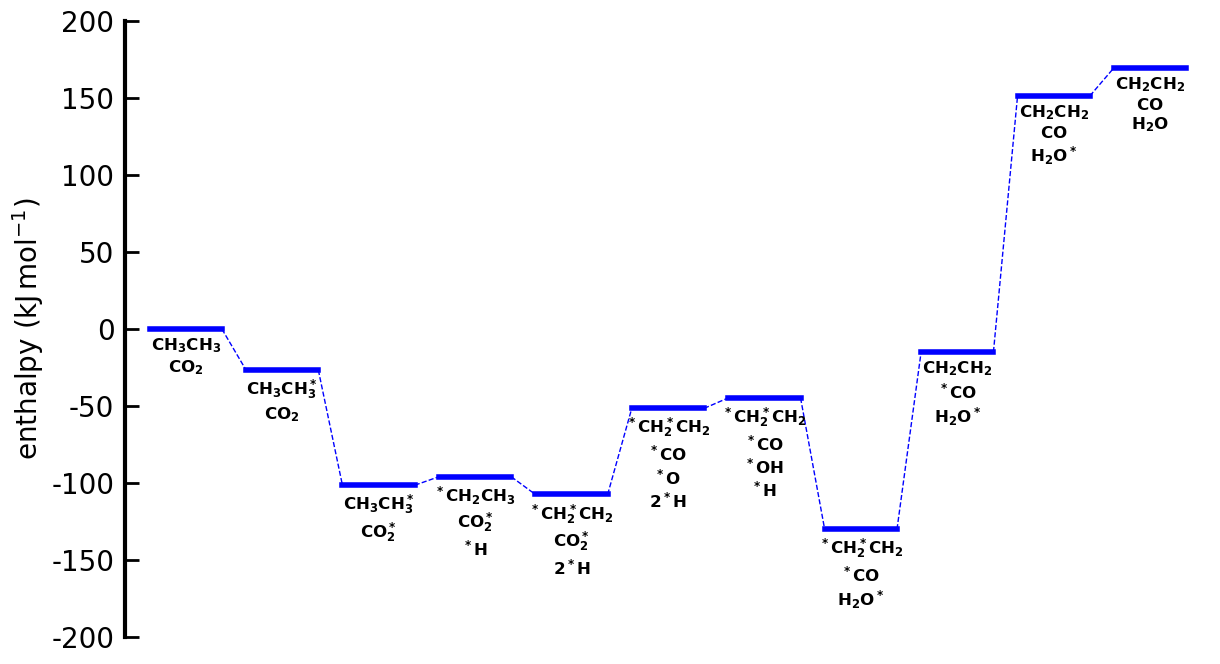

In [19]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.linewidth'] = 3
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['legend.columnspacing'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['axes.formatter.limits'] = (-3, 6)


gs = gridspec.GridSpec(nrows=1, ncols=1)
gs.update(wspace=0.5, hspace=0.5)
ax0 = plt.subplot(gs[0, 0])

ax0.set_ylim([-200,200])
ax0.set_xlim([-1,44])
ax0.get_xaxis().set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_ylabel('$\mathrm{enthalpy\ (kJ\,mol^{-1})}$')


mechanism=({'C2H6':1,'CO2':1},
    {'C2H6X':1,'CO2':1},
    {'C2H6X':1,'CO2X':1},
    {'XCH2CH3':1,'CO2X':1,'XH':1},
    {'XCH2XCH2':1,'CO2X':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XO':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XOH':1,'XH':1},
    {'XCH2XCH2':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'CO':1,'H2OX':1}, 
    {'C2H4':1,'CO':1,'H2O':1},
    )

tags=('$\mathbf{CH_3CH_3}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2^*}$',
      '$\mathbf{^*CH_2CH_3}$\n$\mathbf{CO_2^*}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{CO_2^*}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*O}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*OH}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O}$',
)

# Function to compute the sum for each step in the mechanism
def compute_sum(vec,dictionary):
    return sum(vec[key] * value for key, value in dictionary.items())

def ediagram(ref_system):
    system = [compute_sum(ref_system,entry) for entry in mechanism]
    rel_enthalpies=np.zeros(len(system))
    for i, enthalpies in enumerate(system):
        start = i * 4
        end = start + 3
        ax0.plot((start, end), (enthalpies-system[0], enthalpies-system[0]), linestyle='solid', color='b')
        if i>0:
            ax0.plot((start-1,start),(system[i-1]-system[0],enthalpies-system[0]),linestyle='dashed',color='b', linewidth=1)
        rel_enthalpies[i]=enthalpies-system[0]
    return rel_enthalpies

values=ediagram(enthalpies_of_formation)


for i in range(len(np.array(values).T)):
    start = i * 4
    ax0.text(start+1.5,np.array(values).T[i]-5,tags[i],va='top',ha='center',size=12)